# Destiny 2 Survival Crucible Match Analysis, Enlarged Dataset

## Intro

The purpose of this notebook is to analyse kills, deaths, and assists for both teams and individual guardians in relation to victory.  We will analyse both team metrics and individual metrics as well as looking at metrics for the entire match and per minute (per match data is not available, per minute provides some measure of comperable data).

For the actual analysis, skip done to the Graphs and then the Analysis section at the bottom. 

As for model c values, I did extensive testing with different values of C that is not shown here.  I tended to go for values of C = 6 or lower.

### Imports and Data setup

First we need to setup our environment and import data.  We will be using two datasets, one with team stats and one with guardian stats.

In [26]:
from dotenv import load_dotenv
import requests
import os
import json
import mysql.connector
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt

%matplotlib inline
team_df = pd.read_csv("https://docs.google.com/uc?id=1_0eVAF1TRL7Qn4H8-MMCBrX9jQD5D6n1&export=download")
guardian_df = pd.read_csv("https://docs.google.com/uc?id=1BHXewVacwmtswKBmcFEXliymgitKNnp0&export=download")

And we will remove outliers
- Games shorter than 2 minutes (can assume the match ended with a team leaving)
- Games that did not complete
- Games where there were 0 Kills or Deaths 

In [27]:
team_df = team_df[team_df.standing != 3]
team_df = team_df[(team_df.kills != 0) & (team_df.deaths != 0)]
team_df = team_df.reset_index(drop=True)
guardian_df = guardian_df[guardian_df.completed == 1]
guardian_df = guardian_df[guardian_df.standing != 3]
guardian_df = guardian_df[(guardian_df.kills != 0) & (guardian_df.deaths != 0)]
guardian_df = guardian_df.drop(['completed'], 1)
guardian_df = guardian_df.reset_index(drop=True)

<hr>

## Team Stat Analysis

First, we need to calculate the per minute values

In [28]:
minutes_team_df = team_df.copy()
minutes_team_df['kills'] = minutes_team_df['kills']/(minutes_team_df['duration']/60)
minutes_team_df['assists'] = minutes_team_df['assists']/(minutes_team_df['duration']/60)
minutes_team_df['deaths'] = minutes_team_df['deaths']/(minutes_team_df['duration']/60)

#### Let's Visualize the data

First, let's look at Team Kills and Deaths per match.  Wins are blue, losses are red.

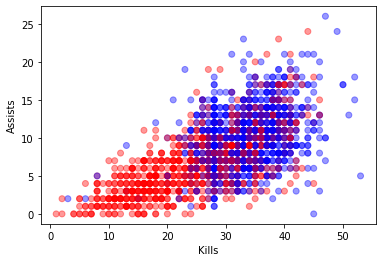

In [29]:
col = np.where(team_df.standing==0,'b','r')
plt.scatter(team_df.kills, team_df.assists,  color=col, alpha=0.4)
plt.xlabel("Kills")
plt.ylabel("Assists")
plt.show()

We can see a strong relation between a higher number of kills and winning and a small relation between high assists and winning.<br>
Now, let's examine the same data but with the per minute data.

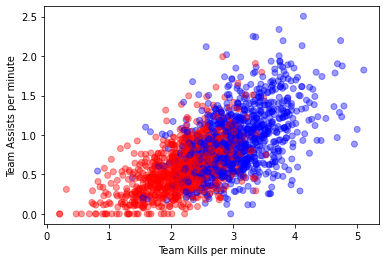

In [30]:
col = np.where(minutes_team_df.standing==0,'b','r')
plt.scatter(minutes_team_df.kills, minutes_team_df.assists,  color=col, alpha=0.4)
plt.xlabel("Team Kills per minute")
plt.ylabel("Team Assists per minute")
plt.show()

The data shows simlar findings.  Team kills/min is very important.  Team assists/min is midly imoprtant

### Create Models

First, we will split our data into train and test sets to confirm our model works on data it was not trained on.  We will also train the model

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = np.asarray(team_df[['kills','deaths','assists']])
y = np.asarray(team_df['standing'])
X_train_team, X_test_team, y_train_team, y_test_team = train_test_split( X, y, test_size=0.2, random_state=4)
X = np.asarray(minutes_team_df[['kills','deaths','assists']])
y = np.asarray(minutes_team_df['standing'])
X_train_team_minutes, X_test_team_minutes, y_train_team_minutes, y_test_team_minutes = train_test_split( X, y, test_size=0.2, random_state=4)
model_team = LogisticRegression(C=.75, solver='liblinear').fit(X_train_team, y_train_team)
model_team_minutes = LogisticRegression(C=6.85, solver='liblinear').fit(X_train_team_minutes, y_train_team_minutes)

Let's check the the accuracy of both models

In [32]:
from sklearn.metrics import f1_score
yhat_team = model_team.predict(X_test_team)
yhat_team_minutes = model_team_minutes.predict(X_test_team_minutes)
team_accuracy = f1_score(y_test_team, yhat_team)
team_minutes_accuracy = f1_score(y_test_team_minutes, yhat_team_minutes)


print (f'Team per game accuracy: {team_accuracy*100:.1f}%')
print (f'Team per minute accuracy: {team_minutes_accuracy*100:.1f}%')

Team per game accuracy: 91.8%
Team per minute accuracy: 91.8%


So, we now have 2 models.  One that is 92.7% accurate and another that is 93.3% accurate at predicting the winner of the match based on team stats.  We will look into the info more in the analysis section.

## Player Stat Analysis

We will be doing the same work on the Player stat info.<br>
First, we need to calculate the per minute values

In [33]:
minutes_guardian_df = guardian_df.copy()
minutes_guardian_df['kills'] = minutes_guardian_df['kills']/(minutes_guardian_df['duration']/60)
minutes_guardian_df['assists'] = minutes_guardian_df['assists']/(minutes_guardian_df['duration']/60)
minutes_guardian_df['deaths'] = minutes_guardian_df['deaths']/(minutes_guardian_df['duration']/60)

#### Let's Visualize the data

First, let's look at Player Kills and Deaths per match.  Wins are blue, losses are red.

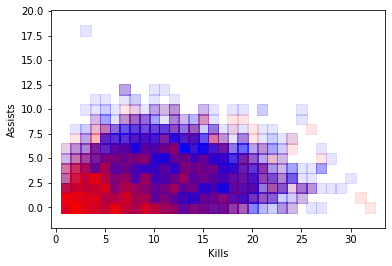

In [34]:
col = np.where(guardian_df.standing==0,'b','r')
plt.scatter(guardian_df.kills, guardian_df.assists,  color=col, alpha=0.1,s = 110, marker = 's')
plt.axis('equal')
plt.xlabel("Kills")
plt.ylabel("Assists")
plt.show()

We can see a strong relation between a higher number of kills and winning and a strong relation between high assists and winning.<br>
Now, let's examine the same data but with the per minute data.

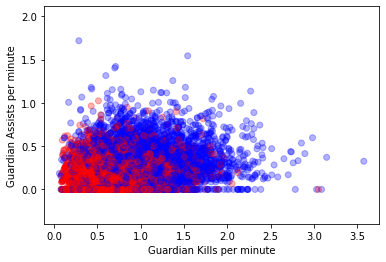

In [35]:
col = np.where(minutes_guardian_df.standing==0,'b','r')
plt.scatter(minutes_guardian_df.kills, minutes_guardian_df.assists,  color=col, alpha=0.3)
plt.axis('equal')
plt.xlabel("Guardian Kills per minute")
plt.ylabel("Guardian Assists per minute")
plt.show()

The data shows simlar findings.  Player kills/min is very important.  Player assists/min is also very important.  Unlike our team data, assists seems to be much more important when considering only a single guardian.

### Create Models

First, we will split our data into train and test sets to confirm our model works on data it was not trained on.  We will also train the model

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X = np.asarray(guardian_df[['kills','deaths','assists']])
y = np.asarray(guardian_df['standing'])
X_train_guardian, X_test_guardian, y_train_guardian, y_test_guardian = train_test_split( X, y, test_size=0.2, random_state=4)
X = np.asarray(minutes_guardian_df[['kills','deaths','assists']])
y = np.asarray(minutes_guardian_df['standing'])
X_train_guardian_minutes, X_test_guardian_minutes, y_train_guardian_minutes, y_test_guardian_minutes = train_test_split( X, y, test_size=0.2, random_state=4)
model_guardian = LogisticRegression(C=.27, solver='liblinear').fit(X_train_guardian, y_train_guardian)
model_guardian_minutes = LogisticRegression(C=6, solver='liblinear').fit(X_train_guardian_minutes, y_train_guardian_minutes)

Let's check the the accuracy of both models

In [14]:
from sklearn.metrics import f1_score
yhat_guardian = model_guardian.predict(X_test_guardian)
yhat_guardian_minutes = model_guardian_minutes.predict(X_test_guardian_minutes)
guardian_accuracy = f1_score(y_test_guardian, yhat_guardian)
guardian_minutes_accuracy = f1_score(y_test_guardian_minutes, yhat_guardian_minutes)


print (f'Team per game accuracy: {guardian_accuracy*100:.1f}%')
print (f'Team per minute accuracy: {guardian_minutes_accuracy*100:.1f}%')

Team per game accuracy: 80.1%
Team per minute accuracy: 79.3%


So, we now have 2 models.  One that is 81.4% accurate and another that is 80.2% accurate at predicting the winner of the match based on a single players stats.  The decreased accuracy makes sense considering we are only considering one member of a 3 guardian fireteam.  

<hr>

## Analysis

All right, here comes the fun part.  Let's figure out what all this means.

Considering we are not putting our personal data in you might be wondering what value the model provides.  The biggest thing we can learn from it is the weighting for each stat.  In short, the model will tell us what stats play the biggest factor in a win.  Do remember that these models are not 100% accurate so the weights do need to be taken with a grain of salt, especially for the guardian stats.<br>
Let's look at Team stats first.
A negative value indicates that the field contributes to a winning (0) probability.  Positive to a lossing (1) probability.  You can caculate probability by multiplying the field times its weight.

In [17]:
cdf_team = pd.concat([pd.DataFrame(['kills','deaths','assists']),pd.DataFrame(np.transpose(model_team.coef_))], axis = 1)
cdf_team_minutes = pd.concat([pd.DataFrame(['kills','deaths','assists']),pd.DataFrame(np.transpose(model_team_minutes.coef_))], axis = 1)

print("Team weights")
print(cdf_team)
print("\nTeam/minute weights")
print(cdf_team_minutes)


Team weights
         0         0
0    kills -0.551933
1   deaths  0.551568
2  assists  0.002647

Team/minute weights
         0         0
0    kills -6.810494
1   deaths  6.839420
2  assists -0.011395


So, from this data we can conclude that kills/deaths per team is much more important than assists, even more so if we just look at per minute.  In fact, having more team assists actually is weighted slightly toward that team losing.  This may not make sense based on the visualization we did early.  Most likely, better teams have good snipers and shotgunners that can kill without needed assist. 

Let's examine Guardian stats

In [18]:
cdf_guardian = pd.concat([pd.DataFrame(['kills','deaths','assists']),pd.DataFrame(np.transpose(model_guardian.coef_))], axis = 1)
cdf_guardian_minutes = pd.concat([pd.DataFrame(['kills','deaths','assists']),pd.DataFrame(np.transpose(model_guardian_minutes.coef_))], axis = 1)

print("Guardian weights")
print(cdf_guardian)
print("\nGuardian/minute weights")
print(cdf_guardian_minutes)

Guardian weights
         0         0
0    kills -0.189349
1   deaths  0.438195
2  assists -0.392971

Guardian/minute weights
         0         0
0    kills -1.851609
1   deaths  5.822666
2  assists -4.195491


Now, we get some really interesting data.  We can see that deaths and assists are for more important than kills for an individual. Over the course of a whole game, it is more important to not die and then get assists then to get kills.  The same goes with per minute with deaths and assists receiving even more weight compared to kills.  In short, if you want your team to win, don't die and play with your team.

## Conclusions

For teams, do not die and get kills.  But, you probably knew that already.<br>
For individuals: focus on not dying, according to the model, that plays the biggest factor in your teams chances of winning, even more than getting kills.  Prioritize survival over kills.  Do your best to team-shot.  One assist can help your team more than one kill.  